In [1]:
#log domain ricatti recursion for bound constraint on both states and controls 
#double integrator example
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/log_domain_ipsolver`


In [2]:
#things to try: square root backward recursion to ensure numerical stability

In [3]:
#the system works with newton with no linesearch...


#need to fix the logic on the backward forward pass alg when reducing the barrier parameter. 
#this formulation seems to be ill conditioned as ρ goes down because G bar is a function of ρ and it gets inversed in the recursion.


#should go down to 1e-6

In [4]:
# here x will be the state [position; velocity ]
# u will be the acceleration, σ is the size of the inequality constraints and dependent on it is the size of the control 

In [5]:
#the only constraint is a set of 2 inequality constraints on the acceleration 

In [6]:
using LinearAlgebra
using ForwardDiff 
using Plots 
using SparseArrays 

In [7]:
#indexing 

function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    #initial condition is assumed to be given 

    #Z vecotr is [u1, x2, u2, x3, u3, x4...]

    nz = (N-1) * nu + (N-1) * nx # length of Z 

    #σ_u will be  a part of u. for this example there are 2 sigmas for every u because of the 2 constraints associated to every control input 
    u = [(i - 1) * (nu + nx) .+ (1 : nu) for i = 1:(N-1)]

    x = [(i - 1) * (nu + nx) .+ ((nu + 1):(nu + nx)) for i = 1:(N - 1)]

    #indices for the lagrange multiplier corresponding to the dynamics constraints
    #this lagrange multipler should be equal to the size of the state
    #it is size (nx, N-1)

    #σ_x will be a part of x. for this example there are 4 sigmas. bound constraints on each of the 2 states
    μ = [(i-1)*(nx + n_ineq_x) .+ ((nz+1):(nz+nx+n_ineq_x)) for i = 1:(N-1)]


    #indexing to build the H matrix (rows)

    H_u= [(i - 1) * (nu + nx + n_ineq_x) .+ (1 : nu) for i = 1:(N-1)]
    
    H_x = [(i - 1) * (nu + nx + n_ineq_x) .+ ((nu + 1):(nu + nx + n_ineq_x)) for i = 1:(N - 1)]

    #indices to create C_bar 



    #indices for the slack variables corresponding to the inequality constraints 
    #there is (N-1)*nu*n_ineq because there is one for each control value has n_ineq constraints 

    #σ = [(i-1)*(nu) .+ ((μ[end][end] + 1):(μ[end][end]+nu)) for i=1:nu*n_ineq*(N-1) ]

    #nσ is the total number of inequality constraints in the problem 
    return (nx=nx,nu=nu,N=N,nz=nz,x= x,u = u, μ = μ, nμ = (nx+n_ineq_x)*(N-1), H_u = H_u, H_x = H_x)
end

create_idx (generic function with 1 method)

In [8]:
#here the state will be Δx, Δu in a Δz vector, the lagrange multipliers Δμ, and finally the slack for the inequalities
#with the log domain substitutions Δσ

In [9]:
#number of inequality control constraints for each control input 
n_ineq = 2

nx = 2     # number of state
#number of true controls 
nc = 1

#number of state inequality constraints for each control input 
#there is two inequalities (upper and lower bound on each elements of the state)
n_ineq_x = 2*nx


#size of agumented control vector with the sigmas 
nu = nc + n_ineq    

3

In [10]:
# Discrete dynamics
h = 0.1   # time step

#for one timestep
A = [1 h; 0 1]
B_normal = [0.5*h*h; h]

#B will be a 2x3 matrix now since every u containts 2 sigmas 
B = [B_normal zeros(size(B_normal)[1], n_ineq)]

B_x_t = [B_normal'  zeros(size(B_normal')[1],n_ineq_x); zeros(nx,nx + n_ineq_x)]

3×6 Matrix{Float64}:
 0.005  0.1  0.0  0.0  0.0  0.0
 0.0    0.0  0.0  0.0  0.0  0.0
 0.0    0.0  0.0  0.0  0.0  0.0

In [11]:
A_t = [A' zeros(nx, n_ineq_x); zeros(n_ineq_x,nx+n_ineq_x)]

6×6 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.1  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [12]:
#this is the number of inequality constraint per control step 
#since this is just for bounds, there are two inequalities 
#Tfinal = 10.0 # final time (orignal )


#will try a shorter time...
Tfinal = 5.0 # final time

#will make it shorter...
#Tfinal = 0.2

#Tfinal = 5.0 # final time (testing )

N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [13]:
idx = create_idx(nx,nu,N)

(nx = 2, nu = 3, N = 51, nz = 250, x = UnitRange{Int64}[4:5, 9:10, 14:15, 19:20, 24:25, 29:30, 34:35, 39:40, 44:45, 49:50  …  204:205, 209:210, 214:215, 219:220, 224:225, 229:230, 234:235, 239:240, 244:245, 249:250], u = UnitRange{Int64}[1:3, 6:8, 11:13, 16:18, 21:23, 26:28, 31:33, 36:38, 41:43, 46:48  …  201:203, 206:208, 211:213, 216:218, 221:223, 226:228, 231:233, 236:238, 241:243, 246:248], μ = UnitRange{Int64}[251:256, 257:262, 263:268, 269:274, 275:280, 281:286, 287:292, 293:298, 299:304, 305:310  …  491:496, 497:502, 503:508, 509:514, 515:520, 521:526, 527:532, 533:538, 539:544, 545:550], nμ = 300, H_u = UnitRange{Int64}[1:3, 10:12, 19:21, 28:30, 37:39, 46:48, 55:57, 64:66, 73:75, 82:84  …  361:363, 370:372, 379:381, 388:390, 397:399, 406:408, 415:417, 424:426, 433:435, 442:444], H_x = UnitRange{Int64}[4:9, 13:18, 22:27, 31:36, 40:45, 49:54, 58:63, 67:72, 76:81, 85:90  …  364:369, 373:378, 382:387, 391:396, 400:405, 409:414, 418:423, 427:432, 436:441, 445:450])

In [14]:
# Initial conditions
#old initial condtion 

#not even log domain newton can solve with this initial condition and limits of 20. probably conditioning on σ
#x0 = [10.0; 0] 

# Initial conditions 
#testing 
#these initial conditions are working!! will comment out to try to find the bug..
x_initial = [1.0; 0.0]

μ_initial = [0.2; 0.1; 0.01; 0.02; 0.01; 0.03]

u_initial = [0.5; 0.01; 0.02]

##################################################################################


#works with this 
#μ0 = [0.0; 0.0]

#put values on μ to test out the residual function 
#both newton and ricatti match for this initial condition. 
#μ0 = [0.0; 0.0; 0.01; 0.02; 0.01; 0.03]


#try new initial guess 
# u0 = [0.0, 0.0, 0.0]

#initial barrier parameter 
ρ0 = 0.1

#define control bounds 
#umin = -20.0
#umax = 20.0

#try smaller values for the bounds? 
#residual does not go down to tight tolerances with large bounds...
#umin = -2.5
#umax = 2.5

#working with these control constraints
umin = -1.5
umax = 1.5


#umin = -0.8
#umax = 1.25


#xmin = -1.5

xmin = 0
xmax = 1.5

#try these bounds..
#doesn't go down to tight tolerances 
vmin = -0.5
vmax = 0.5

#new bounds
#vmin = -0.75
#vmax = 0.75

0.5

In [15]:
#another initial condition to see why it only matches at the initial solve 

#named as the og 

#this initial condtiion does solve. does not match after the first step. why
# x_initial = [1.5, 0.1]
# u_initial = [0.1, 0.2, 0.15]
# μ_initial = [0.2, 0.4, 0.23, 0.22, 0.21, 0.45]

In [16]:
#bound constraints for this example 
# Gu - h - s >= 0 

Gu = [1.0; -1.0] 

Gx = [1.0*Matrix(I,2,2); -1.0*Matrix(I,2,2)]

hu = [umin; -umax]

hx = [xmin; vmin; -xmax; -vmax]

4-element Vector{Float64}:
  0.0
 -0.5
 -1.5
 -0.5

In [17]:
#create an initial state/control trajectory 

#pass in indices, and initial state 
function create_initial_states(idx, x_ic, u_ic, μ_ic)

    #slacks are part of nz now 
    z0 = zeros(idx.nz)

    μ0 = zeros(idx.nμ)    

    initial_states = zeros(nx, N)

    initial_states[:,1] = x_ic

    #will just rollout the initial state with no control input as the initial guess trajectory 
    for i=1:N-1

        initial_states[:, i+1] = A*initial_states[:,i] + B*u_ic

    end

    #save the states in z
    for i=1:N-1

        z0[idx.u[i]] = u_ic
        z0[idx.x[i]] = initial_states[:,i+1]

        μ0[idx.μ[i] .- idx.nz] = μ_ic
    
    end

    #initial guess for the lagrange multipliers as well as the σ terms for x  . initialize as zeros 
    #μ0 = zeros(idx.nμ)


    #it was initializing everything to 0.1 before...
    #μ0 = 0.1*ones(idx.nμ)


    return z0, μ0
    
end

create_initial_states (generic function with 1 method)

In [18]:
#bug maybe here? 

function create_w(idx, xhist, uhist, μhist)

    w = zeros(idx.nz + idx.nμ)

    #fill in x
    #we do not include x1 in the state
    #starting at x2
    for i=1:size(idx.x)[1]

        w[idx.x[i]] = xhist[:,i+1]

    end

    #fill in u
    for i=1:size(idx.u)[1]

        w[idx.u[i]] = uhist[:, i]

    end


    #fill in μ
    for i=1:size(idx.μ)[1]

        w[idx.μ[i]] = μhist[:,i]

    end

    return w

end

create_w (generic function with 1 method)

In [19]:
#works for one step with this intitial condition 
#z0, μ0  = create_initial_states(idx, x_initial, u_initial, μ_initial) 


z0_nc, μ0_nc  = create_initial_states(idx, x_initial, u_initial, μ_initial) 

([0.5, 0.01, 0.02, 1.0025, 0.05, 0.5, 0.01, 0.02, 1.0099999999999998, 0.1  …  0.5, 0.01, 0.02, 7.002500000000005, 2.4499999999999993, 0.5, 0.01, 0.02, 7.250000000000005, 2.499999999999999], [0.2, 0.1, 0.01, 0.02, 0.01, 0.03, 0.2, 0.1, 0.01, 0.02  …  0.01, 0.02, 0.01, 0.03, 0.2, 0.1, 0.01, 0.02, 0.01, 0.03])

In [20]:
#stack all the initial states into one vector w 

#works with this initial condition, will change the name to see if there is a global anywhere 
#w0 = [z0; μ0]


w0_nc = [z0_nc; μ0_nc]

550-element Vector{Float64}:
 0.5
 0.01
 0.02
 1.0025
 0.05
 0.5
 0.01
 0.02
 1.0099999999999998
 0.1
 ⋮
 0.02
 0.01
 0.03
 0.2
 0.1
 0.01
 0.02
 0.01
 0.03

In [21]:
#create another initial condition

#this is named the original 
#z0_2, μ0_2  = create_initial_states(idx, x_initial_2, u_initial_2, μ_initial_2) 

In [22]:
#w0_2 = [z0_2; μ0_2]

In [23]:
#original_w0 = [z0; μ0]

In [24]:
# Cost weights

Q_1 = Array(1.0*I(idx.nx))
R_1 = 0.1 #Array(1.0*I(1))
Qn_1 = Array(1.0*I(idx.nx))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [25]:
Gx 

4×2 Matrix{Float64}:
  1.0   0.0
  0.0   1.0
 -1.0  -0.0
 -0.0  -1.0

In [26]:
nc 

1

In [27]:
n_ineq 

2

In [28]:
#this makes H of the true cost function 

function create_H_res(idx, z, ρ)

    #creat H and fill it in 

    #not square anymore with the inequalities on the states
    H = zeros(idx.H_x[end][end], idx.nz)

    for i = 1:N-1

        #size 3x3 for this example 
        #first is for the stationarity condition 
        #other two rows are for the control bound constraint 
        R_bar_res = [R_1 zeros(nc,n_ineq); Gu zeros(n_ineq,n_ineq)]


        Q_bar_res = [Q_1; Gx]
        
        #indexed 1x2 because this expresses 2 KKT conditions and it is a function of 3 variables 
        H[idx.H_u[i], idx.u[i]] = R_bar_res
    
        H[idx.H_x[i], idx.x[i]] = Q_bar_res
    
    end

    #fill in terminal cost matrix if it is different than the stage cost Q

    H[idx.H_x[end], idx.x[end]] = [Qn_1; Gx] 

    return H 

end

create_H_res (generic function with 1 method)

In [29]:
Gu 

2-element Vector{Float64}:
  1.0
 -1.0

In [30]:
Q_1 

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [31]:
#H_test_res =  create_H_res(idx, z0, ρ0)

In [32]:
#H will be changing now because the R terms are dependent on the value of σ
#this is the jacobian of the kkt residual function that we will solve using ricatti 
function create_H(idx, z, ρ)

    H = zeros(idx.H_x[end][end], idx.nz)

    for i = 1:N-1

        #size 3x2 for this example 
        #first is for the stationarity condition 
        #other two rows are for the control bound constraint 
        R_bar = [R_1 Gu'*diagm(sqrt(ρ)*exp.(-z[idx.u[i]][nc+1:end])); Gu diagm(-sqrt(ρ)*exp.(z[idx.u[i]][nc+1:end]))]

        Q_bar = [Q_1; Gx]
        
        #indexed 1x2 because this expresses 2 KKT conditions and it is a function of 3 variables 
        H[idx.H_u[i], idx.u[i]] = R_bar
    
        H[idx.H_x[i], idx.x[i]] = Q_bar
    
    end

    #fill in terminal cost matrix if it is different than the stage cost Q

    H[idx.H_x[end], idx.x[end]] = [Qn_1; Gx]  

    return H 

end

create_H (generic function with 1 method)

In [33]:
#C_bar = zeros(idx.H_x[end][end], idx.nμ)

In [34]:
A_t 

6×6 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0
 0.1  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [35]:
nx 

2

In [36]:
function create_C_bar(idx , w, ρ)

    C_bar = zeros(idx.H_x[end][end], idx.nμ)

    #fill in all terms related to u's

    for i=1:N-1 

        C_bar[idx.H_u[i], idx.μ[i] .- idx.nz] = B_x_t        

    end

    for i = 1:N-2


        G_bar = [-1.0*Matrix(I, 2,2) Gx'*diagm(sqrt(ρ)*exp.(-w[idx.μ[i][nx+1:end]])); 
        
        zeros(n_ineq_x,nx) diagm(-sqrt(ρ)*exp.(w[idx.μ[i][nx+1:end]]))]

        C_bar[idx.H_x[i], idx.μ[i] .- idx.nz] = G_bar  

        C_bar[idx.H_x[i], idx.μ[i+1] .- idx.nz] = A_t  

        
    end

    #fill in last row of C_bar 

    #fills in timestep N-1
    
    G_bar_end = [-1.0*Matrix(I, 2,2) Gx'*diagm(sqrt(ρ)*exp.(-w[idx.μ[end][nx+1:end]])); 
    zeros(n_ineq_x,nx) diagm(-sqrt(ρ)*exp.(w[idx.μ[end][nx+1:end]]))]

    C_bar[idx.H_x[end], idx.μ[end] .- idx.nz] = G_bar_end

    return C_bar 

end 

create_C_bar (generic function with 1 method)

In [37]:
#C bar checked 

#testing_Cbar = create_C_bar(idx , w0, ρ0)

In [38]:
#testing_Cbar[1:end, 1:6]

In [39]:
#testing_Cbar[1:end, end-5:end]

In [40]:
function create_C_bar_res(idx , w, ρ)

    C_bar_res = zeros(idx.H_x[end][end], idx.nμ)

    #fill in all terms related to u's

    for i=1:N-1 

        C_bar_res[idx.H_u[i], idx.μ[i] .- idx.nz] = B_x_t        

    end

    for i = 1:N-2

        G_bar = [-1.0*Matrix(I, nx,nx) zeros(nx, n_ineq_x); 
        
        zeros(n_ineq_x,nx+n_ineq_x)]

        C_bar_res[idx.H_x[i], idx.μ[i] .- idx.nz] = G_bar  

        C_bar_res[idx.H_x[i], idx.μ[i+1] .- idx.nz] = A_t  
        
    end

    #fill in last row of C_bar 

    G_bar_end = [-1.0*Matrix(I, nx,nx) zeros(nx, n_ineq_x); 
    zeros(n_ineq_x,nx+n_ineq_x)]
    
    C_bar_res[idx.H_x[end], idx.μ[end] .- idx.nz] = G_bar_end

    return C_bar_res

end 

create_C_bar_res (generic function with 1 method)

In [41]:
#c bar test checked and looks good 
#C_bar_test = create_C_bar_res(idx, w0, ρ0)

In [42]:
#C_bar_test = create_C_bar(idx, w0, ρ0)

In [43]:
#this matrix is checked
#H_test =  create_H(idx, z0, ρ0)

In [44]:
#pass in initial condtion 

function create_C_d(x0)

    #defining all LQR problem as a QP, write down concatanated matrices C and G, as well as their corresponding vectors 
    #Cz = d 
    #Gz -h >= 0

    #for this example C is [200, 500] and d is size 200
    C = zeros((N-1)*nx , idx.nz) 

    #negative identity at each of the state indices
    for i=1:size(idx.x)[1]

        C[(i-1)*nx.+(1 : nx), idx.x[i]] = -1.0 *Matrix(I, idx.nx, idx.nx)

    end

    #initialize the first row 
    C[1:nx, idx.u[1]] = B 

    for i=1:size(idx.x)[1]-1

        #A matrix at each of the state indices, starting at row 2
        C[i*nx.+(1 : nx), idx.x[i]] = A

        #B matrix at each of the control indices, starting at row 2
        C[i*nx.+(1 : nx), idx.u[i+1]] = B

    end

    #create d 
    d = zeros(nx*(N-1))

    #the bug may be here...
    d[1:2] = -A*x0



    return C, d 
end

create_C_d (generic function with 1 method)

In [45]:
C, d = create_C_d(x_initial)

([0.005000000000000001 0.0 … 0.0 0.0; 0.1 0.0 … 0.0 0.0; … ; 0.0 0.0 … -1.0 -0.0; 0.0 0.0 … -0.0 -1.0], [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [46]:
#test out the constraint 
constraint_test = C*z0_nc - d
#test if all are equal to zero 
all(constraint_test .== 0) 

#checked 

true

In [47]:
#TODO 
#need to create G all 
# G_all = zeros(idx.nz, idx.nμ*n_ineq)

In [48]:
#TODO: use this as the exit condition for the ip newtons method 
# function true_kkt_conditions(w)

#     z = w[1:idx.nz]

#     μ = w[idx.nz+1:end]
    
#     #create λ 
#     λ_sol = zeros(idx.nμ*n_ineq)

#     for i=1:N-1

#         λ_sol[1:2] = sqrt
#     end

#     #create H 
#     H = create_H_res(idx, z, ρ)

#     stationarity_residual = H*z + C'*μ - G_all*λ

# end

In [49]:
#residual function for the KKT system with log domain substitutions

#right hand size of the nonlinear KKT system as well

#will be evaluating this residual function at the trajectories we are evaluating newton on 

function residual_function(w, ρ)

    #pick out each value from w 

    #contains x and u 
    #u contains the sigmas 
    z = w[1:idx.nz]
    #μ = w[idx.nz+ 1: idx.nz + idx.nμ]

    μ = w[idx.nz+1:end]

    #build the h for the stationarity residual

    #affine term for the stationarity residual and inequality residual 
    h_res = zeros(idx.H_x[end][end])

    #C_bar = create_C_bar(idx , w, ρ)

    #need to update this!
    for i=1:N-1


        #these are the affine terms on the kkt conditions
        h_res[idx.H_u[i][1]] = Gu'*(sqrt(ρ)*exp.(-z[idx.u[i]][nc+1:end]))

        h_res[idx.H_u[i][nc+1:end]] = (hu + sqrt(ρ)*exp.(z[idx.u[i]][nc+1:end])) 

        h_res[idx.H_x[i][1:nx]] = Gx'*(sqrt(ρ)*exp.(-w[idx.μ[i]][nx+1:end]))

        #hx are the state limits
        
        h_res[idx.H_x[i][nx+1:end]] = (hx + sqrt(ρ)*exp.(w[idx.μ[i]][nx+1:end])) 


    end

    #gradient of lagrangian = 0, and the inequality constraints kkt condition in one 
    #this contains the stationarity residual and the inequality constraints Gu - h - s 

    #create H and C for the residual function 
    H_res = create_H_res(idx, z, ρ)

    C_bar_res = create_C_bar_res(idx, z, ρ)
        
    #fix this stationarity residual 

    #the H function is the jacobian. it is not for the residual check function
    stationarity_residual = H_res*z + C_bar_res*μ - h_res
    
    #equality constraints
    primal_feasibility_1 = C*z - d

    residual = [stationarity_residual; primal_feasibility_1]

    #this is the residual we want to converge to in Newtons method 
    return residual

end

residual_function (generic function with 1 method)

In [50]:
#residual function is good 

In [51]:
#residual_function(w0, ρ0)[1:18]

In [52]:
#Gx*w0[idx.x[1]] - hx - sqrt(ρ0)*exp.(w0[idx.μ[1][nx+1:end]])

In [53]:
#Gx*w0[idx.x[end]] - hx - sqrt(ρ0)*exp.(w0[idx.μ[end][nx+1:end]])

In [54]:
#Gx'*sqrt(ρ0)*exp.(w0[idx.μ[1][nx+1:end]])

In [55]:
#matches the residual 
#Q_1*w0[idx.x[1]] + A'*w0[idx.μ[2]][1:2] - w0[idx.μ[1]][1:2]

In [56]:
#A'*w0[idx.μ[2]][1:2] - w0[idx.μ[1]][1:2]

In [57]:
#residual function checked

In [58]:
function newton_step(w_newton, ρ)

    #for i=1
        
        H_test_newton = create_H(idx, w_newton, ρ)

        C_bar_test_newton = create_C_bar(idx , w_newton, ρ)

        #updated newton 
        newton_step= [H_test_newton C_bar_test_newton; C zeros((N-1)*nx, idx.nμ)]\(-residual_function(w_newton, ρ)) 


        println("condition number of matrix: ", cond([H_test_newton C_bar_test_newton; C zeros((N-1)*nx, idx.nμ)]))
        #println(newton_step)

        #w_newton_2 = w_newton + newton_step

    #end

    return newton_step
    
end

newton_step (generic function with 1 method)

In [59]:
#newton is working
#this newton step should be the same as one backward and forward pass
newton_step_1 = newton_step(w0_nc, ρ0)

condition number of matrix: 1409.2456368841379


550-element Vector{Float64}:
 -1.049254046129415
  1.9766072898138454
  5.351991548957148
 -0.005246270230648609
 -0.1049254046129417
 -0.9456278850971948
  2.3010413671698213
  5.030785644608298
 -0.020466950117421945
 -0.19948819312266053
  ⋮
  0.48668013382637604
  2.160360315280225
  0.5969308118176365
 -0.22419299836595297
 -0.1581997779515425
  0.5293499742163614
  0.4841070685162952
  2.166868733361256
  0.5994782747001077

In [60]:
#newton_step_ic_2 = newton_step(w0_2, ρ0)
#state_2_ic_2 = w0_2 + newton_step_ic_2 

In [61]:
newton_2 = w0_nc + newton_step_1

550-element Vector{Float64}:
 -0.5492540461294151
  1.9866072898138454
  5.371991548957148
  0.9972537297693513
 -0.054925404612941695
 -0.44562788509719475
  2.311041367169821
  5.050785644608298
  0.9895330498825778
 -0.09948819312266052
  ⋮
  0.506680133826376
  2.1703603152802247
  0.6269308118176365
 -0.024192998365952956
 -0.05819977795154249
  0.5393499742163614
  0.5041070685162952
  2.176868733361256
  0.6294782747001078

In [62]:
newton_step_2 = newton_step(newton_2, ρ0)

condition number of matrix: 13418.558373497903


550-element Vector{Float64}:
 -1.5853811556159558
 -1.2752653674858394
 -0.9466131198706643
 -0.007926905778078086
 -0.1585381155615977
 -0.8932139214434835
 -0.9494664420233777
 -0.9425072797599944
 -0.02824678694146182
 -0.24785950770594622
  ⋮
 -0.05092459347598358
 -0.5474827231390296
 -0.15216315980288395
  0.040771718307438067
  0.051818280991772804
 -0.5461849455291921
 -0.047037367282118665
 -0.5503650742237203
 -0.1555923752044357

In [63]:
newton_3 = newton_2 + newton_step_2 

550-element Vector{Float64}:
 -2.134635201745371
  0.711341922328006
  4.425378429086483
  0.9893268239912733
 -0.2134635201745394
 -1.3388418065406782
  1.3615749251464435
  4.108278364848303
  0.9612862629411161
 -0.3473477008286068
  ⋮
  0.4557555403503924
  1.622877592141195
  0.4747676520147526
  0.01657871994148511
 -0.006381496959769688
 -0.006834971312830618
  0.4570697012341765
  1.6265036591375357
  0.47388589949567206

In [64]:
#norm(residual_function(newton_3, ρ0)) 

In [65]:
initial_newton = w0_nc

550-element Vector{Float64}:
 0.5
 0.01
 0.02
 1.0025
 0.05
 0.5
 0.01
 0.02
 1.0099999999999998
 0.1
 ⋮
 0.02
 0.01
 0.03
 0.2
 0.1
 0.01
 0.02
 0.01
 0.03

In [66]:
ρ1 = ρ0

0.1

In [67]:
max_newton_iters = 10

10

In [68]:
#solve with newton with decreasing the barrier

In [69]:
function newton_solve(initial_newton, ρ)

    for i=1:max_newton_iters 

        Δz = newton_step(initial_newton, ρ)

        initial_newton += Δz 

        #check the residual 
        residual = norm(residual_function(initial_newton, ρ))

        println("Iteration ", i, " residual:", residual)

        if residual < ρ

            return initial_newton, residual

        end

    end

    println("Failed to converge")


end

newton_solve (generic function with 1 method)

In [70]:
for i=1:6

    println("Iteration", i, " ρ: ", ρ1) 
    
    initial_newton, residual = newton_solve(initial_newton, ρ1)

    println("Iteration ", i, " residual :", residual)
    #update ρ1 

    ρ1 = 0.1*ρ1

end 

Iteration1 ρ: 0.1
condition number of matrix: 1409.2456368841379
Iteration 1 residual:147.08249279281043
condition number of matrix: 13418.558373497903
Iteration 2 residual:50.148477457298256
condition number of matrix: 7592.438219793507
Iteration 3 residual:15.646141027728897
condition number of matrix: 3364.5198993014933
Iteration 4 residual:3.8315872822016415
condition number of matrix: 1634.2030670248432
Iteration 5 residual:0.6060884040602948
condition number of matrix: 1060.5219122113904
Iteration 6 residual:0.03766461261607962
Iteration 1 residual :0.03766461261607962
Iteration2 ρ: 0.010000000000000002
condition number of matrix: 981.8817306136643
Iteration 1 residual:38.86388587189518
condition number of matrix: 2078.4032476289435
Iteration 2 residual:10.675666589497121
condition number of matrix: 1177.7762492251566
Iteration 3 residual:1.8166712240687963
condition number of matrix: 819.5280436776183
Iteration 4 residual:0.09641553977820112
condition number of matrix: 753.43404

In [71]:
# x_solution_traj = zeros(nx, N)

# u_solution_traj = zeros(nc, N-1)

# x_solution_traj[:,1] = x0

# for i=1:N-1

#     x_solution_traj[:, i+1] = initial_newton[idx.x[i]]
#     u_solution_traj[1, i] = initial_newton[idx.u[i]][1]


# end

In [72]:
#the problem solves with newton with no linesearch 

In [73]:
#newtons method to check if the problem can be solved
# newton_x = zeros(550, 15)
# newton_residuals = zeros(15)



# newton_x[:,1] = w0

# newton_residuals[1] = norm(residual_function(w0, 1e-1))


In [74]:
#problem solving with newton...
# for i =1:15-1

#     step = newton_step(newton_x[:,i], 1e-1)
    
#     newton_x[:,i+1] = newton_x[:,i] + step 

#     newton_residuals[i+1] = norm(residual_function(newton_x[:,i+1], 1e-1)) 


# end

In [75]:
# x_solution_traj = zeros(nx, N)

# u_solution_traj = zeros(nc, N-1)

# x_solution_traj[:,1] = x0

# for i=1:N-1

#     x_solution_traj[:, i+1] = newton_x[:,3][idx.x[i]]
#     u_solution_traj[1, i] = newton_x[:,3][idx.u[i]][1]


# end

In [76]:
#cost-to-go terms (defined globally)
# P = zeros(nx + n_ineq_x ,nx,N)
# q = zeros(nx + n_ineq_x, N)

# #feedback terms
# K = zeros(nu,nx,N-1)
# f = zeros(nu, N-1)

In [77]:
# #obtain the linear feedback control law as well as the cost to go 
#original ricatti recursion that is working
# function ricatti_recursion(w, ρ)

#     #z here is the reference trajectory, here the control law is solving for deltas
#     #initialize the final matrices

#     z = w[1:idx.nz]

#     affine_term = -residual_function(w, ρ)

#     G_bar_N = [-1.0*Matrix(I, 2,2) Gx'*diagm(sqrt(ρ)*exp.(-w[idx.μ[end][nx+1:end]])); 
        
#         zeros(n_ineq_x,nx) diagm(-sqrt(ρ)*exp.(w[idx.μ[end][nx+1:end]]))]
        

#     P[:,:,N] = -G_bar_N\[Qn_1; Gx]

#     #println(cond(-G_bar_N))

#     q[:,N] = -G_bar_N\affine_term[idx.H_x[end]]

#     #create H 
#     #jacobian version of H 
    
#     H = create_H(idx, z, ρ)
        
#     for k=N-1:-1:2

#         G_k = [-1.0*Matrix(I, 2,2) Gx'*diagm(sqrt(ρ)*exp.(-w[idx.μ[k][nx+1:end]])); 
        
#         zeros(n_ineq_x,nx) diagm(-sqrt(ρ)*exp.(w[idx.μ[k][nx+1:end]]))]

#         #println(cond(G_k))

#         R_k = H[idx.H_u[k], idx.u[k]]

#         Q_k = H[idx.H_x[k], idx.x[k]] 

#         #add the 2 times the exponential term
#         K[:,:,k] = (R_k + B_x_t *P[:,:,k+1]*B)\(-B_x_t*P[:,:,k+1]*A)

#         f[:,k] = (R_k + B_x_t*P[:,:,k+1]*B)\(B_x_t*q[:,k+1] + affine_term[idx.H_u[k]])

#         P[:, :, k] = -G_k\(Q_k + A_t*P[:,:,k+1]*A + A_t*P[:,:,k+1]*B*K[:,:,k])

#         q[:,k] = -G_k\(-A_t*P[:,:,k+1]*B*f[:,k] + A_t*q[:,k+1] + affine_term[idx.H_x[k-1]])


#     end

#     #there is no cost to go affine term at timestep 1 because x1 is not part of the cost
#     # in this formualtion, but we can still calculate the feedback gain K and affine control f 
#     k = 1

#     R_k = H[idx.H_u[k], idx.u[k]]
#     #feedback and feedforward terms at index 1 
#     K[:,:,k] = (R_k + B_x_t *P[:,:,k+1]*B)\(-B_x_t*P[:,:,k+1]*A)

#     f[:,k] = (R_k + B_x_t*P[:,:,k+1]*B)\(B_x_t*q[:,k+1] + affine_term[idx.H_u[k]])

#     return K, f, P, q
    
# end

In [78]:
#potential bug in the indexing of μ and u. 

#the initial condition I am setting it at, all of them are the same. 

#check what happens when I set each of the intiial conditions to a different variable. see if the first steps still match up...

In [79]:
w0_nc 

550-element Vector{Float64}:
 0.5
 0.01
 0.02
 1.0025
 0.05
 0.5
 0.01
 0.02
 1.0099999999999998
 0.1
 ⋮
 0.02
 0.01
 0.03
 0.2
 0.1
 0.01
 0.02
 0.01
 0.03

In [80]:
w0_nc[idx.μ[end]]

6-element Vector{Float64}:
 0.2
 0.1
 0.01
 0.02
 0.01
 0.03

In [81]:
#obtain the linear feedback control law as well as the cost to go 

#will try to fix the conditioning via regularization 

#condition number on newton is way worse 
function ricatti_recursion(w, ρ)

    #z here is the reference trajectory, here the control law is solving for deltas
    #initialize the final matrices

    #reg = 1.0e-3

    #turn off regularization 
    reg = 0.0

    P = zeros(nx + n_ineq_x ,nx,N)
    q = zeros(nx + n_ineq_x, N)

    #feedback terms
    K = zeros(nu,nx,N-1)
    f = zeros(nu, N-1)


    z = w[1:idx.nz]

    affine_term = -residual_function(w, ρ)

    G_bar_N = [-1.0*Matrix(I, 2,2) Gx'*diagm(sqrt(ρ)*exp.(-w[idx.μ[end][nx+1:end]])); 
        
        zeros(n_ineq_x,nx) diagm(-sqrt(ρ)*exp.(w[idx.μ[end][nx+1:end]]))] + reg*Matrix(I, nx+n_ineq_x, nx+n_ineq_x)
        

    P[:,:,N] = -G_bar_N\[Qn_1; Gx]

    #println("size GN: ", size(-G_bar_N))

    println("condition number GN: ", cond(-G_bar_N))

    q[:,N] = -G_bar_N\affine_term[idx.H_x[end]]

    #create H 
    #jacobian version of H 
    H = create_H(idx, z, ρ)
        
    for k=N-1:-1:2

        #the bug is here 
        G_k = [-1.0*Matrix(I, 2,2) Gx'*diagm(sqrt(ρ)*exp.(-w[idx.μ[k-1][nx+1:end]])); 
        
        zeros(n_ineq_x,nx) diagm(-sqrt(ρ)*exp.(w[idx.μ[k-1][nx+1:end]]))] + reg*Matrix(I, nx+n_ineq_x, nx+n_ineq_x)

        #println(cond(G_k))

        R_k = H[idx.H_u[k], idx.u[k]]

        Q_k = H[idx.H_x[k], idx.x[k]] 

        #add the 2 times the exponential term
        #og equation
        #K[:,:,k] = (R_k + B_x_t *P[:,:,k+1]*B)\(-B_x_t*P[:,:,k+1]*A)

        #regularized equation 
        K[:,:,k] = ((R_k + B_x_t*P[:,:,k+1]*B)+ reg*Matrix(I, nc + n_ineq , nc + n_ineq))\(-B_x_t*P[:,:,k+1]*A)

        #og equation 
        #f[:,k] = (R_k + B_x_t*P[:,:,k+1]*B)\(B_x_t*q[:,k+1] + affine_term[idx.H_u[k]])

        #regularized quation 
        f[:,k] = ((R_k + B_x_t*P[:,:,k+1]*B) + reg*Matrix(I, nc + n_ineq , nc + n_ineq))\(B_x_t*q[:,k+1] + affine_term[idx.H_u[k]])

        P[:, :, k] = -G_k\(Q_k + A_t*P[:,:,k+1]*A + A_t*P[:,:,k+1]*B*K[:,:,k])

        q[:,k] = -G_k\(-A_t*P[:,:,k+1]*B*f[:,k] + A_t*q[:,k+1] + affine_term[idx.H_x[k-1]])


        #print the condition numbers and sizes.
        #println("size RK +: ", size((R_k + B_x_t *P[:,:,k+1]*B)))

        println("condition number RK + ", cond((R_k + B_x_t *P[:,:,k+1]*B)))

        println("condition number GK: ", cond(G_k))



    end

    #there is no cost to go affine term at timestep 1 because x1 is not part of the cost
    # in this formualtion, but we can still calculate the feedback gain K and affine control f 
    k = 1

    R_k = H[idx.H_u[k], idx.u[k]]
    #feedback and feedforward terms at index 1 
    K[:,:,k] = (R_k + B_x_t *P[:,:,k+1]*B)\(-B_x_t*P[:,:,k+1]*A)

    f[:,k] = (R_k + B_x_t*P[:,:,k+1]*B)\(B_x_t*q[:,k+1] + affine_term[idx.H_u[k]])

    return K, f, P, q
    
end

ricatti_recursion (generic function with 1 method)

In [82]:
K_test, f_test, P_test, q_test = ricatti_recursion(w0_nc, ρ0)

condition number GN: 3.8008854350457386
condition number RK + 4.518487827318932
condition number GK: 3.8008854350457386
condition number RK + 4.521404250457766
condition number GK: 3.8008854350457386
condition number RK + 4.5262770584679055
condition number GK: 3.8008854350457386
condition number RK + 4.5330363171249735
condition number GK: 3.8008854350457386
condition number RK + 4.541540294981628
condition number GK: 3.8008854350457386
condition number RK + 4.551579522744462
condition number GK: 3.8008854350457386
condition number RK + 4.562886822454805
condition number GK: 3.8008854350457386
condition number RK + 4.5751530051822815
condition number GK: 3.8008854350457386
condition number RK + 4.588046688680851
condition number GK: 3.8008854350457386
condition number RK + 4.601235731377082
condition number GK: 3.8008854350457386
condition number RK + 4.614407447317981
condition number GK: 3.8008854350457386
condition number RK + 4.627285137219247
condition number GK: 3.80088543504573

([-1.0917451624158654 -1.8308792958446432; -3.418049370429835 -5.732139733641434; 3.3840392109405064 5.675103990318701;;; -1.0916515107422957 -1.8307759198705105; -3.417756164602226 -5.731816082852343; 3.3837489225596276 5.67478355990877;;; -1.0915355331457293 -1.8306487688390425; -3.4173930604964555 -5.731417996817231; 3.3833894314000763 5.674389434895888;;; … ;;; -0.06170800348331787 -0.4145952872272032; -0.19319618691041482 -1.298020095966605; 0.19127385273162945 1.2851045802148169;;; -0.02810315729211293 -0.2794793384889253; -0.08798571534481141 -0.874997398528739; 0.08711024284943217 0.8662910289443326;;; -0.0071504154166630255 -0.14092910232032335; -0.02238660976445621 -0.4412225911725486; 0.02216385927550738 0.43683235303675894], [-1.0492540461293884 -1.1434498880682584 … -1.357832646007307 -0.9030116599680392; 1.9766072898139289 1.6816977730876979 … 1.010505560810736 2.434464776301741; 5.3519915489570655 5.6439666669629185 … 6.308480405141459 4.898689820578995], [0.0 0.0; 0.0 0

In [83]:
#pass in the current tractory as well as the feedback control law 
#everything is in terms of deltas from the reference trajectory 

#x0 defined above 

#no linesearch here 

#w here is the reference 
function forward_pass(x0, w, K, f, P, q, ρ)

    #initial step size 
    α = 1

    #state trajectory
    z = w[1:idx.nz]

    #lagrange multipliers 
    μ = w[idx.nz+ 1: idx.nz + idx.nμ]
    
    xhist = zeros(nx, N)
    xhist[:,1] = x0 

    #this is the reference trajectory based off w 
    xtraj = zeros(nx, N)
    xtraj[:,1] = x0 
    
    #for i=2:N

    #    xtraj[:,i] = w[idx.x[i-1]]

    #end

    for i=1:N-1

        xtraj[:,i+1] = w[idx.x[i]]

    end

    uhist = zeros(nu, N-1)

    #this sigma is from 2:N
    μhist = zeros(nx+n_ineq_x, N-1)

    #the minus sign is in K 

    Δu_1 = (K[:,:,1]*(xhist[:,1] - xtraj[:,1])) + f[:,1]

    #since 1 is size 1, have to pick it out of the 1 element vector
    uhist[:,1] = w[idx.u[1]] + Δu_1

    #forward simulate first control
    xhist[:,2] = A*xhist[:,1] + B*uhist[:,1]

    #check that the step was good, if not take a smaller step


    #update the controls, lagrange multipliers, and sigmas 
    for k=2:N-1

        #KΔx + d is Δu, so we apply that to the current u reference trajectory stored in z0
        
        Δu_k = (K[:,:,k]*(xhist[:,k] - xtraj[:,k])) + f[:,k]
        
        Δμ_k = P[:,:,k]*(xhist[:,k] - xtraj[:,k]) - q[:,k] 

        uhist[:,k] = w[idx.u[k]] + Δu_k

        #apply a forward rollout on the dynamics with this control 
        xhist[:,k+1] = A*xhist[:,k] + B*uhist[:,k]

        #update the lagrage multipliers μ
        μhist[:,k-1] = w[idx.μ[k-1]] + Δμ_k 

    end

    #fill in lagrange multiplier at timestep N 
    Δμ_N = P[:,:,N]*(xhist[:,N] - xtraj[:,N]) - q[:,N] 

    #mu at the end 
    μhist[:,end] = w[idx.μ[end]] + Δμ_N


    #create w here 

    new_state = create_w(idx, xhist, uhist, μhist)

    #create w 

    #check the cost 

    #implement the armijo law 

    #if cost doesn't go down, take 1/2 of the size and run the sim again

    #return xhist, uhist, μhist

    return new_state

end

forward_pass (generic function with 1 method)

In [84]:
function forward_pass_og(w, K, f, P, q, ρ)

    #initial step size 
    α = 1

    #state trajectory
    z = w[1:idx.nz]

    #lagrange multipliers 
    μ = w[idx.nz+ 1: idx.nz + idx.nμ]
    
    xhist = zeros(nx, N)
    xhist[:,1] = x0 

    #this is the reference trajectory based off w 
    xtraj = zeros(nx, N)
    xtraj[:,1] = x0 
    for i=2:N

        xtraj[:,i] = w[idx.x[i-1]]

    end

    uhist = zeros(nu, N-1)

    #this sigma is from 2:N
    μhist = zeros(nx + n_ineq, N-1)

    #the minus sign is in K 

    Δu_1 = (K[:,:,1]*(xhist[:,1] - xtraj[:,1])) + f[:,1]

    #since 1 is size 1, have to pick it out of the 1 element vector
    uhist[:,1] = w[idx.u[1]] + Δu_1

    #forward simulate first control
    xhist[:,2] = A*xhist[:,1] + B*uhist[:,1]

    #check that the step was good, if not take a smaller step



    #update the controls, lagrange multipliers, and sigmas 
    for k=2:N-1

        #KΔx + d is Δu, so we apply that to the current u reference trajectory stored in z0
        
        Δu_k = (K[:,:,k]*(xhist[:,k] - xtraj[:,k])) + f[:,k]
        
        Δμ_k = P[:,:,k]*(xhist[:,k] - xtraj[:,k]) - q[:,k] 

        uhist[:,k] = w[idx.u[k]] + Δu_k

        #apply a forward rollout on the dynamics with this control 
        xhist[:,k+1] = A*xhist[:,k] + B*uhist[:,k]

        #update the lagrage multipliers μ
        μhist[:,k-1] = w[idx.μ[k-1]] + Δμ_k 

    end

    #fill in lagrange multiplier at timestep N 
    Δμ_N = P[:,:,N]*(xhist[:,N] - xtraj[:,N]) - q[:,N] 

    #mu at the end 
    μhist[:,end] = w[idx.μ[end]] + Δμ_N



    #create w 

    #check the cost 

    #implement the armijo law 

    #if cost doesn't go down, take 1/2 of the size and run the sim again

    return xhist, uhist, μhist

end

forward_pass_og (generic function with 1 method)

In [85]:
#maximum iterations on the forward pass linesearch 
max_linesearch_iters = 20

20

In [86]:
# #adding an armijo linesearch on the forward rollout

# #forward pass with a linesearch 

# #this code is in v2

# function forward_pass_ls(w, K, f, P, q, ρ)

#     #state trajectory
#     z = w[1:idx.nz]

#     #lagrange multipliers 
#     μ = w[idx.nz+ 1: idx.nz + idx.nμ]
    
#     #parameter for the linesearch 
#     b = 0.01

#     xhist = zeros(nx, N)
#     xhist[:,1] = x0 

#     #this is the reference trajectory based off w 
#     xtraj = zeros(nx, N)
#     xtraj[:,1] = x0 
#     for i=2:N

#         xtraj[:,i] = w[idx.x[i-1]]

#     end

#     uhist = zeros(nu, N-1)

#     #this sigma is from 2:N
#     μhist = zeros(nx + n_ineq_x, N-1)

#     #initial step size 
#     α = 1.0

#     for i =1:max_linesearch_iters

#         #forward rollout 
#         for k=1:N-1
            
#             Δu_k = (K[:,:,k]*(xhist[:,k] - xtraj[:,k])) + α*f[:,k]

#             #+1 because there is no ctg calculated at k=1
#             #adding alpha here...
#             Δμ_k = P[:,:,k+1]*(xhist[:,k] - xtraj[:,k]) - q[:,k+1] 

#             uhist[:,k] = w[idx.u[k]] + Δu_k

#             #apply a forward rollout on the dynamics with this control 
#             xhist[:,k+1] = A*xhist[:,k] + B*uhist[:,k]

#             #update the lagrage multipliers μ
#             μhist[:,k] = w[idx.μ[k]] + Δμ_k 
            
#         end

#         #create w and evaluate the cost 
#         new_w = create_w(idx, xhist, uhist, μhist)

#         #this is the delta from the forward pass
#         new_delta = new_w - w

#         #call the create H function here 
#         H_w = create_H(idx, w, ρ)

#         C_bar_t = create_C_bar(idx , w, ρ)

#         #jacobian of the residual function 
#         jac = [H_w C_bar_t; 
#         C zeros((N-1)*nx, idx.nμ)] 

#         #this is the gradient of the L2 norm of the residual function
#         grad = (w' * jac)/norm(residual_function(w, ρ))

#         println("norm with alpha step: ", norm(residual_function(new_w, ρ)))

#         println("norm original: ", norm(residual_function(w, ρ)))
#         #the merit function is the l2 norm of the kkt residual 
#         #simple linesearch (working)
#         if norm(residual_function(w + α*new_delta, ρ)) < norm(residual_function(w, ρ))
        
#         #armijo linesearch
#         #if norm(residual_function(w + α*new_delta, ρ)) < norm(residual_function(w, ρ)) + b*α*grad*new_delta 

#             return xhist, uhist, μhist, α, new_w

#         else
#             α = 0.5*α

#         end

#     end

#     println("linesearch failed ")

# end

In [87]:
#the indexing was wrong when updating the duals. fixed to match the version
#with no linesearch. need to fix this in v2 as well

function forward_pass_ls_new(x0, w, K, f, P, q, ρ)

    #state trajectory
    z = w[1:idx.nz]

    #lagrange multipliers 
    μ = w[idx.nz+ 1: idx.nz + idx.nμ]
    
    #parameter for the linesearch 
    #b = 0.01

    #tunign b 

    #this works up to tolerance 1e-4
    #b = 0.001

    b = 0.01

    xhist = zeros(nx, N)
    xhist[:,1] = x0 

    #this is the reference trajectory based off w 
    xtraj = zeros(nx, N)
    xtraj[:,1] = x0 
    for i=2:N

        xtraj[:,i] = w[idx.x[i-1]]

    end

    uhist = zeros(nu, N-1)

    #this sigma is from 2:N
    μhist = zeros(nx + n_ineq_x, N-1)

    #initial step size 
    α = 1.0


    for i =1:max_linesearch_iters

        Δu_1 = (K[:,:,1]*(xhist[:,1] - xtraj[:,1])) + α*f[:,1]

        uhist[:,1] = w[idx.u[1]] + Δu_1

        xhist[:,2] = A*xhist[:,1] + B*uhist[:,1]


        #forward rollout 
        for k=2:N-1
            
            Δu_k = (K[:,:,k]*(xhist[:,k] - xtraj[:,k])) + α*f[:,k]

            #+1 because there is no ctg calculated at k=1
            #adding alpha here...
            #Δμ_k = P[:,:,k+1]*(xhist[:,k] - xtraj[:,k]) - q[:,k+1] 

            Δμ_k = P[:,:,k]*(xhist[:,k] - xtraj[:,k]) - α*q[:,k] 

            uhist[:,k] = w[idx.u[k]] + Δu_k

            #apply a forward rollout on the dynamics with this control 
            xhist[:,k+1] = A*xhist[:,k] + B*uhist[:,k]

            #update the lagrage multipliers μ
            μhist[:,k-1] = w[idx.μ[k-1]] + Δμ_k 
            
        end

        #fill in lagrange multiplier at timestep N 
        Δμ_N = P[:,:,N]*(xhist[:,N] - xtraj[:,N]) - α*q[:,N] 

        #mu at the end 
        μhist[:,end] = w[idx.μ[end]] + Δμ_N

        #create w and evaluate the cost 
        new_w = create_w(idx, xhist, uhist, μhist)

        #evaluate the cost
        Jn = norm(residual_function(new_w, ρ))

        #this is the delta from the forward pass
        new_delta = new_w - w

        #call the create H function here 
        H_w = create_H(idx, w, ρ)

        C_bar_t = create_C_bar(idx , w, ρ)

        #jacobian of the residual function 
        jac = [H_w C_bar_t; 
        C zeros((N-1)*nx, idx.nμ)] 

        #this is the gradient of the L2 norm of the residual function
        grad = (w' * jac)/norm(residual_function(w, ρ))

        #println("norm with alpha step: ", Jn)

        #println("norm original: ", norm(residual_function(w, ρ)))

        #the merit function is the l2 norm of the kkt residual 
        #simple linesearch (working)
        #compare the cost of new w and w 

        #this only works for up to 1e-2 ρ
        if Jn < norm(residual_function(w, ρ))
        #armijo linesearch
        #if Jn < norm(residual_function(w, ρ)) + b*α*grad*new_delta 

            #return xhist, uhist, μhist, α, new_w
            #println("returning solution ")
            return new_w 

        else
            
            #println("decreaseing alpha ")

            α = 0.5*α

        end

    end

    println("linesearch failed ")

end

forward_pass_ls_new (generic function with 1 method)

In [88]:
#linesearch on all Δz

function forward_pass_ls_dz(x0, w, K, f, P, q, ρ)

    #state trajectory
    z = w[1:idx.nz]

    #lagrange multipliers 
    μ = w[idx.nz+ 1: idx.nz + idx.nμ]
    
    #parameter for the linesearch 
    #b = 0.01

    #tunign b 

    #this works up to tolerance 1e-4
    #b = 0.001

    b = 0.0001

    xhist = zeros(nx, N)
    xhist[:,1] = x0 

    #this is the reference trajectory based off w 
    xtraj = zeros(nx, N)
    xtraj[:,1] = x0 
    for i=2:N

        xtraj[:,i] = w[idx.x[i-1]]

    end

    uhist = zeros(nu, N-1)

    #this sigma is from 2:N
    μhist = zeros(nx + n_ineq_x, N-1)

    #initial step size 
    α = 1.0



        Δu_1 = (K[:,:,1]*(xhist[:,1] - xtraj[:,1])) + α*f[:,1]

        uhist[:,1] = w[idx.u[1]] + Δu_1

        xhist[:,2] = A*xhist[:,1] + B*uhist[:,1]


        #forward rollout 
        for k=2:N-1
            
            Δu_k = (K[:,:,k]*(xhist[:,k] - xtraj[:,k])) + α*f[:,k]

            #+1 because there is no ctg calculated at k=1
            #adding alpha here...
            #Δμ_k = P[:,:,k+1]*(xhist[:,k] - xtraj[:,k]) - q[:,k+1] 

            Δμ_k = P[:,:,k]*(xhist[:,k] - xtraj[:,k]) - α*q[:,k] 

            uhist[:,k] = w[idx.u[k]] + Δu_k

            #apply a forward rollout on the dynamics with this control 
            xhist[:,k+1] = A*xhist[:,k] + B*uhist[:,k]

            #update the lagrage multipliers μ
            μhist[:,k-1] = w[idx.μ[k-1]] + Δμ_k 
            
        end

        #fill in lagrange multiplier at timestep N 
        Δμ_N = P[:,:,N]*(xhist[:,N] - xtraj[:,N]) - α*q[:,N] 

        #mu at the end 
        μhist[:,end] = w[idx.μ[end]] + Δμ_N

        #create w and evaluate the cost 
        new_w = create_w(idx, xhist, uhist, μhist)

        #evaluate the cost
        Jn = norm(residual_function(new_w, ρ))

        #this is the delta from the forward pass
        new_delta = new_w - w

        #call the create H function here 
        H_w = create_H(idx, w, ρ)

        C_bar_t = create_C_bar(idx , w, ρ)

        #jacobian of the residual function 
        jac = [H_w C_bar_t; 
        C zeros((N-1)*nx, idx.nμ)] 

        #this is the gradient of the L2 norm of the residual function
        grad = (w' * jac)/norm(residual_function(w, ρ))

        #println("norm with alpha step: ", Jn)

        #println("norm original: ", norm(residual_function(w, ρ)))

        #the merit function is the l2 norm of the kkt residual 
        #simple linesearch (working)
        #compare the cost of new w and w 

        #this only works for up to 1e-2 ρ
        #if Jn < norm(residual_function(w, ρ))

    for i =1:max_linesearch_iters
        #armijo linesearch
        if norm(residual_function(w+α*new_delta, ρ)) < norm(residual_function(w, ρ)) + b*α*grad*new_delta 

            #return xhist, uhist, μhist, α, new_w
            #println("returning solution ")

            new_w = w + α*new_delta

            
            return new_w 

        else
            
            #println("decreaseing alpha ")

            α = 0.5*α

        end

    end

    println("linesearch failed ")

end

forward_pass_ls_dz (generic function with 1 method)

In [89]:
# #adding an armijo linesearch on the forward rollout

# #forward pass with a linesearch 

# #this code is in v2

# function forward_pass_ls(w, K, f, P, q, ρ)

#     #state trajectory
#     z = w[1:idx.nz]

#     #lagrange multipliers 
#     μ = w[idx.nz+ 1: idx.nz + idx.nμ]
    
#     #parameter for the linesearch 
#     #b = 0.01

#     #tunign b 

#     b = 0.01

#     xhist = zeros(nx, N)
#     xhist[:,1] = x0 

#     #this is the reference trajectory based off w 
#     xtraj = zeros(nx, N)
#     xtraj[:,1] = x0 
#     for i=2:N

#         xtraj[:,i] = w[idx.x[i-1]]

#     end

#     uhist = zeros(nu, N-1)

#     #this sigma is from 2:N
#     μhist = zeros(nx + n_ineq_x, N-1)

#     #initial step size 
#     α = 1.0


#     for i =1:max_linesearch_iters

#         #println("this is alpha: ", α)

#         #forward rollout 
#         for k=1:N-1
            
#             Δu_k = (K[:,:,k]*(xhist[:,k] - xtraj[:,k])) + α*f[:,k]

#             #+1 because there is no ctg calculated at k=1
#             #adding alpha here...
#             #Δμ_k = P[:,:,k+1]*(xhist[:,k] - xtraj[:,k]) - q[:,k+1] 

#             Δμ_k = P[:,:,k+1]*(xhist[:,k] - xtraj[:,k]) - α*q[:,k+1] 

#             uhist[:,k] = w[idx.u[k]] + Δu_k

#             #apply a forward rollout on the dynamics with this control 
#             xhist[:,k+1] = A*xhist[:,k] + B*uhist[:,k]

#             #update the lagrage multipliers μ
#             μhist[:,k] = w[idx.μ[k]] + Δμ_k 
            
#         end

#         #create w and evaluate the cost 
#         new_w = create_w(idx, xhist, uhist, μhist)

#         #evaluate the cost
#         Jn = norm(residual_function(new_w, ρ))

#         #this is the delta from the forward pass
#         new_delta = new_w - w

#         #call the create H function here 
#         H_w = create_H(idx, w, ρ)

#         C_bar_t = create_C_bar(idx , w, ρ)

#         #jacobian of the residual function 
#         jac = [H_w C_bar_t; 
#         C zeros((N-1)*nx, idx.nμ)] 

#         #this is the gradient of the L2 norm of the residual function
#         grad = (w' * jac)/norm(residual_function(w, ρ))

#         #println("norm with alpha step: ", Jn)

#         #println("norm original: ", norm(residual_function(w, ρ)))

#         #the merit function is the l2 norm of the kkt residual 
#         #simple linesearch (working)
#         #compare the cost of new w and w 

#         #this only works for up to 1e-2 ρ
#         if Jn < norm(residual_function(w, ρ))

#         #armijo linesearch
#         #if Jn < norm(residual_function(w, ρ)) + b*α*grad*new_delta 

#             #return xhist, uhist, μhist, α, new_w
#             #println("returning solution ")
#             return new_w 

#         else
            
#             #println("decreaseing alpha ")

#             α = 0.5*α

#         end

#     end

#     println("linesearch failed ")

# end

In [90]:
#forward pass with a linesearch 

#this formulatiion doesn't seem to work...
# function forward_pass_ls(w, K, f, P, q, ρ)

#     #state trajectory
#     z = w[1:idx.nz]

#     #lagrange multipliers 
#     μ = w[idx.nz+ 1: idx.nz + idx.nμ]
    
#     #parameter for the linesearch 
#     b = 0.01

#     xhist = zeros(nx, N)
#     xhist[:,1] = x0 

#     #this is the reference trajectory based off w 
#     xtraj = zeros(nx, N)
#     xtraj[:,1] = x0 
#     for i=2:N

#         xtraj[:,i] = w[idx.x[i-1]]

#     end

#     uhist = zeros(nu, N-1)

#     #this sigma is from 2:N
#     μhist = zeros(nx + n_ineq_x, N-1)

#     #initial step size 
#     α = 1.0


#     #forward rollout 
#     for k=1:N-1
            
#         Δu_k = (K[:,:,k]*(xhist[:,k] - xtraj[:,k])) + α*f[:,k]

#         #+1 because there is no ctg calculated at k=1
#         Δμ_k = P[:,:,k+1]*(xhist[:,k] - xtraj[:,k]) - q[:,k+1] 

#         uhist[:,k] = w[idx.u[k]] + Δu_k

#         #apply a forward rollout on the dynamics with this control 
#         xhist[:,k+1] = A*xhist[:,k] + B*uhist[:,k]

#         #update the lagrage multipliers μ
#         μhist[:,k] = w[idx.μ[k]] + Δμ_k 
        
#     end


#      #create w and evaluate the cost 
#      new_w = create_w(idx, xhist, uhist, μhist)

#      #this is the delta from the forward pass
#      new_delta = new_w - w

#     #call the create H function here 
#     H_w = create_H(idx, w, ρ)

#     C_bar_t = create_C_bar(idx , w, ρ)

#     #jacobian of the residual function 
#     jac = [H_w C_bar_t; 
#     C zeros((N-1)*nx, idx.nμ)] 

#     #this is the gradient of the L2 norm of the residual function
#     grad = (w' * jac)/norm(residual_function(w, ρ))

#     for i =1:max_linesearch_iters

#         #the merit function is the l2 norm of the kkt residual 
#         #simple linesearch (working)
#         #if norm(residual_function(w + α*new_delta, ρ)) < norm(residual_function(w, ρ))
        
#         println("cost with delta: ", norm(residual_function(w + α*new_delta, ρ)))
        
#         println("expected cost first order taylor: ", norm(residual_function(w, ρ)) + b*α*grad*new_delta)
#         #armijo linesearch
#         if norm(residual_function(w + α*new_delta, ρ)) < norm(residual_function(w, ρ)) + b*α*grad*new_delta 

#             new_w = w + α*new_delta 

#             return new_w

#         else
#             α = 0.5*α

#         end

#     end

#     println("linesearch failed ")

# end

In [91]:
new_w  = forward_pass(x_initial, w0_nc, K_test, f_test, P_test, q_test, ρ0)

550-element Vector{Float64}:
 -0.5492540461293884
  1.9866072898139289
  5.371991548957065
  0.997253729769353
 -0.05492540461293885
 -0.44562788509717177
  2.3110413671698926
  5.050785644608228
  0.9895330498825733
 -0.09948819312265603
  ⋮
  0.5066801338263889
  2.1703603152802575
  0.6269308118176251
 -0.024192998365982266
 -0.0581997779515305
  0.5393499742163306
  0.5041070685163072
  2.176868733361287
  0.629478274700096

In [92]:
#test out forward pass with linesearch



#new_w_ls = forward_pass_ls_new(x_initial, w0_nc, K_test, f_test, P_test, q_test, ρ0)

In [93]:
#test out forward pass with dz linesearch 
#new_w_ls_dz = forward_pass_ls_dz(x_initial, w0_nc, K_test, f_test, P_test, q_test, ρ0)

In [94]:
#w_ls = create_w(idx, xhist_test_ls, uhist_test_ls, μhist_test_ls) 

In [95]:
#norm(residual_function(w_ls, ρ0)) 

In [96]:
#plot(uhist_test') 

In [97]:
#uhist_test 

In [98]:
#stack up the solution into the w vector 
#w_1 = create_w(idx, xhist_test, uhist_test, μhist_test) 

In [99]:
#this is the step that the ricatti recursion makes after one iteration. it should match the newton step 
step_ricatti = new_w - w0_nc 

550-element Vector{Float64}:
 -1.0492540461293884
  1.9766072898139289
  5.3519915489570655
 -0.005246270230646943
 -0.10492540461293885
 -0.9456278850971718
  2.301041367169893
  5.030785644608229
 -0.020466950117426497
 -0.19948819312265603
  ⋮
  0.48668013382638886
  2.1603603152802577
  0.5969308118176251
 -0.22419299836598228
 -0.1581997779515305
  0.5293499742163306
  0.48410706851630714
  2.1668687333612873
  0.599478274700096

In [100]:
newton_step_1

550-element Vector{Float64}:
 -1.049254046129415
  1.9766072898138454
  5.351991548957148
 -0.005246270230648609
 -0.1049254046129417
 -0.9456278850971948
  2.3010413671698213
  5.030785644608298
 -0.020466950117421945
 -0.19948819312266053
  ⋮
  0.48668013382637604
  2.160360315280225
  0.5969308118176365
 -0.22419299836595297
 -0.1581997779515425
  0.5293499742163614
  0.4841070685162952
  2.166868733361256
  0.5994782747001077

In [101]:
#good for one step 
difference = step_ricatti - newton_step_1 

550-element Vector{Float64}:
  2.6645352591003757e-14
  8.348877145181177e-14
 -8.260059303211165e-14
  1.6653345369377348e-15
  2.8449465006019636e-15
  2.298161660974074e-14
  7.149836278586008e-14
 -6.927791673660977e-14
 -4.551914400963142e-15
  4.496403249731884e-15
  ⋮
  1.2823075934420558e-14
  3.2862601528904634e-14
 -1.1435297153639112e-14
 -2.930988785010413e-14
  1.199040866595169e-14
 -3.086420008457935e-14
  1.1934897514720433e-14
  3.108624468950438e-14
 -1.176836406102666e-14

In [102]:
#why is it able to solve with backslash but not with the ricatti recursion? 

In [103]:
# K_test_ic_2, f_test_ic_2, P_test_ic_2, q_test_ic_2 = ricatti_recursion(w0_2 , ρ0)

# new_w_ic_2 = forward_pass(x_initial_2, w0_2, K_test_ic_2, f_test_ic_2, P_test_ic_2, q_test_ic_2, ρ0)

In [104]:
#there is a bug. just works for w0 for some reason. maybe theres a w0 call somewhere...

In [105]:
# new_w_ic_2 - state_2_ic_2

In [106]:
# duals = new_w[idx.nz+1:end] 

In [107]:
# lagrange_multipliers = zeros(2, 100)

# for i=1:N-1

#     lagrange_multipliers[:,i] = duals[6*(i-1).+(1:2)]

# end

In [108]:
#dual update may be off? 

In [109]:
# plot(lagrange_multipliers')

In [110]:
K_test_2, f_test_2, P_test_2, q_test_2 = ricatti_recursion(new_w , ρ0)

new_w_2 = forward_pass(x_initial, new_w, K_test_2, f_test_2, P_test_2, q_test_2, ρ0)

#condition number in the 100's for this state. might be the bug? 

condition number GN: 5.472532816297815
condition number RK + 109.16105781321536
condition number GK: 5.423403529642403
condition number RK + 96.78757134639672
condition number GK: 5.380616885528972
condition number RK + 90.7061627039639
condition number GK: 5.343497757028346
condition number RK + 87.85683091187202
condition number GK: 5.311444810423985
condition number RK + 86.65818450237144
condition number GK: 5.283926356762724
condition number RK + 86.26173459728666
condition number GK: 5.260472908272473
condition number RK + 86.25003189404919
condition number GK: 5.2406664325745735
condition number RK + 86.43381404065974
condition number GK: 5.224127479175211
condition number RK + 86.73360168492604
condition number GK: 5.210501965690283
condition number RK + 87.11945558470029
condition number GK: 5.199449259052943
condition number RK + 87.58225989453402
condition number GK: 5.190632489924656
condition number RK + 88.12061418109587
condition number GK: 5.183711222450442
condition nu

550-element Vector{Float64}:
 -2.1346352017454198
  0.7113419223280912
  4.425378429086406
  0.9893268239912729
 -0.21346352017454198
 -1.338841806540694
  1.3615749251465061
  4.108278364848238
  0.9612862629411153
 -0.3473477008286114
  ⋮
  0.4557555403503932
  1.622877592141212
  0.47476765201475063
  0.0165787199414828
 -0.006381496959769917
 -0.00683497131284061
  0.4570697012341758
  1.6265036591375512
  0.4738858994956713

In [111]:
ricatti_step_2 = new_w_2 - new_w 

550-element Vector{Float64}:
 -1.5853811556160313
 -1.2752653674858376
 -0.9466131198706593
 -0.007926905778080084
 -0.15853811556160313
 -0.8932139214435222
 -0.9494664420233865
 -0.9425072797599903
 -0.02824678694145799
 -0.24785950770595536
  ⋮
 -0.050924593475995705
 -0.5474827231390456
 -0.15216315980287448
  0.040771718307465066
  0.051818280991760585
 -0.5461849455291712
 -0.04703736728213137
 -0.5503650742237358
 -0.1555923752044247

In [112]:
newton_step_2 

550-element Vector{Float64}:
 -1.5853811556159558
 -1.2752653674858394
 -0.9466131198706643
 -0.007926905778078086
 -0.1585381155615977
 -0.8932139214434835
 -0.9494664420233777
 -0.9425072797599944
 -0.02824678694146182
 -0.24785950770594622
  ⋮
 -0.05092459347598358
 -0.5474827231390296
 -0.15216315980288395
  0.040771718307438067
  0.051818280991772804
 -0.5461849455291921
 -0.047037367282118665
 -0.5503650742237203
 -0.1555923752044357

In [113]:
step_difference_2 = ricatti_step_2 - newton_step_2 

550-element Vector{Float64}:
 -7.549516567451064e-14
  1.7763568394002505e-15
  4.9960036108132044e-15
 -1.9984014443252818e-15
 -5.440092820663267e-15
 -3.863576125695545e-14
 -8.770761894538737e-15
  4.107825191113079e-15
  3.83026943495679e-15
 -9.131584377541913e-15
  ⋮
 -1.2122247650125928e-14
 -1.5987211554602254e-14
  9.46465128492946e-15
  2.6999236180103026e-14
 -1.2219392164780629e-14
  2.0872192862952943e-14
 -1.2705114738054135e-14
 -1.554312234475219e-14
  1.099120794378905e-14

In [114]:
norm(step_difference_2) 

2.96506397765657e-12

In [115]:
#initial residual 
# residual_0 = residual_function(w0, ρ0)

In [116]:
#number of backward and forward passes
num_iters = 25

25

In [117]:
# residuals = zeros(num_iters)

# all_α = zeros(num_iters)

In [118]:
# w_1 

In [119]:
# all_iters[:,1] = w0

# residuals[1] = norm(residual_function(w0, ρ0))

In [120]:
# tol = 1e-5

In [121]:
# num_iters 

In [122]:
# ρ0 

In [123]:
#this changes the original all_iters matrix bc the arguments are passed in by reference 

#this logic needs fixing...
function ricatti_solve(x_ricatti, ρ)
    #run a couple iterations 
    
    for i =1:num_iters-1

        K_test, f_test, P_test, q_test = ricatti_recursion(x_ricatti, ρ)

        #forward pass w linesearch 
        #works for tolerance 1e-4
        #new_w = forward_pass_ls_new(x_ricatti, K_test, f_test, P_test, q_test, ρ)

        #forward pass with dz linesearch
        #works up to tolerance 1e-4 too
        #new_w = forward_pass_ls_dz(x_ricatti, K_test, f_test, P_test, q_test, ρ)

        #no linesearch
        #only works for the first iteration
        new_w = forward_pass(x_initial, x_ricatti, K_test, f_test, P_test, q_test, ρ)

        x_ricatti = new_w
        
        #check the residual on the updated ricatti 
        residual_ricatti = norm(residual_function(x_ricatti, ρ))

        println("this is the residual: ", residual_ricatti)

        #all_iters[:,i+1] = new_w

        #residuals[i+1] = norm(residual_function(all_iters[:,i+1], ρ))

        #println(residuals[i+1])
        #all_α[i] = α_test

        #user defined tolerance 
        #if residuals[i+1] < tol 

        #or use the barrier parameter as a tolerance 
        if residual_ricatti < ρ 

        #if residuals[i+1] < tol 
            return x_ricatti, residual_ricatti

        end

    end

    println("Failed to convert to tolerance")
    println("Final residual of: ", residual_ricatti)

end

ricatti_solve (generic function with 1 method)

In [124]:
#this is working!
x_ricatti, residual_ricatti = ricatti_solve(w0_nc, ρ0)

condition number GN: 3.8008854350457386
condition number RK + 4.518487827318932
condition number GK: 3.8008854350457386
condition number RK + 4.521404250457766
condition number GK: 3.8008854350457386
condition number RK + 4.5262770584679055
condition number GK: 3.8008854350457386
condition number RK + 4.5330363171249735
condition number GK: 3.8008854350457386
condition number RK + 4.541540294981628
condition number GK: 3.8008854350457386
condition number RK + 4.551579522744462
condition number GK: 3.8008854350457386
condition number RK + 4.562886822454805
condition number GK: 3.8008854350457386
condition number RK + 4.5751530051822815
condition number GK: 3.8008854350457386
condition number RK + 4.588046688680851
condition number GK: 3.8008854350457386
condition number RK + 4.601235731377082
condition number GK: 3.8008854350457386
condition number RK + 4.614407447317981
condition number GK: 3.8008854350457386
condition number RK + 4.627285137219247
condition number GK: 3.80088543504573

([-1.1962259440845822, -0.04015039078939523, 2.156136922036639, 0.9940188702795771, -0.11962259440845822, -1.0198095047726177, 0.4177277669535384, 2.0802361480271263, 0.9769575633148682, -0.22160354488571998  …  -0.09512344774856123, 0.4476895819421476, 1.3439493189838232, 0.468492993779383, 0.021084592234007212, -0.008638851008526401, -0.0968638448275169, 0.44850068459370085, 1.3443616103538847, 0.4676979348621804], 0.03766461261606857)

In [125]:
x_newton, residual_newton = newton_solve(w0_nc, ρ0) 

condition number of matrix: 1409.2456368841379
Iteration 1 residual:147.08249279281043
condition number of matrix: 13418.558373497903
Iteration 2 residual:50.148477457298256
condition number of matrix: 7592.438219793507
Iteration 3 residual:15.646141027728897
condition number of matrix: 3364.5198993014933
Iteration 4 residual:3.8315872822016415
condition number of matrix: 1634.2030670248432
Iteration 5 residual:0.6060884040602948
condition number of matrix: 1060.5219122113904
Iteration 6 residual:0.03766461261607962


([-1.1962259440845822, -0.04015039078939493, 2.1561369220366426, 0.9940188702795771, -0.11962259440845821, -1.0198095047726174, 0.41772776695353847, 2.0802361480271276, 0.9769575633148683, -0.22160354488571998  …  -0.09512344774856046, 0.44768958194214753, 1.343949318983823, 0.46849299377938297, 0.02108459223400781, -0.008638851008526523, -0.09686384482751605, 0.4485006845937007, 1.3443616103538847, 0.4676979348621806], 0.03766461261607962)

In [126]:
x_ricatti_2, residual_ricatti_2 = ricatti_solve(x_ricatti, 0.01)

condition number GN: 11.156304356038135
condition number RK + 22.773309527467173
condition number GK: 11.136444107759877
condition number RK + 21.08565209893365
condition number GK: 11.114427377765349
condition number RK + 19.890395666798415
condition number GK: 11.08910431900393
condition number RK + 19.092393716098606
condition number GK: 11.059517110463498
condition number RK + 18.565692496212982
condition number GK: 11.024837706990738
condition number RK + 18.207910099513093
condition number GK: 10.984322269520337
condition number RK + 17.95112634687797
condition number GK: 10.937278301160752
condition number RK + 17.75502614206001
condition number GK: 10.883041712371314
condition number RK + 17.597276032516277
condition number GK: 10.820961877251507
condition number RK + 17.46601319526178
condition number GK: 10.750393338396973
condition number RK + 17.354990065748005
condition number GK: 10.670693239461059
condition number RK + 17.260739797204028
condition number GK: 10.581223854

([-1.45252101837029, -0.7448830114168843, 3.3852609378902163, 0.9927373949081485, -0.145252101837029, -1.3939499432755225, 0.05874121416578228, 3.365237479559403, 0.971242435008068, -0.2846470961645813  …  0.010809509145966586, 1.6015918541813332, 2.6383231237959386, 1.617226472011567, 0.008564450318021851, -0.003879070667410134, 0.007092739235394044, 1.6022304649298134, 2.638591001017592, 1.6165973677763243], 0.0004078713324382691)

In [127]:
x_ricatti_3, residual_ricatti_3 = ricatti_solve(x_ricatti_2, 0.001)

condition number GN: 31.430366121022963
condition number RK + 39.365804060414696
condition number GK: 31.313535133220125
condition number RK + 36.29749535268099
condition number GK: 31.183711392235065
condition number RK + 34.10573442997197
condition number GK: 31.033588965762892
condition number RK + 32.61861802479273
condition number GK: 30.856938003971447
condition number RK + 31.613372961942076
condition number GK: 30.64825894946317
condition number RK + 30.91152838523867
condition number GK: 30.402550348690323
condition number RK + 30.39655879628736
condition number GK: 30.115167302215685
condition number RK + 30.000382222849638
condition number GK: 29.78175551149486
condition number RK + 29.68552517093438
condition number GK: 29.398250530888795
condition number RK + 29.431593689406387
condition number GK: 28.960934139331393
condition number RK + 29.22686970265968
condition number GK: 28.46654020379361
condition number RK + 29.063711978521663
condition number GK: 27.91240133525498

([-1.4948211959582507, -1.8093034690862364, 4.550765487587502, 0.9925258940202087, -0.14948211959582508, -1.4868123501281867, -0.8745968628164679, 4.548090035208382, 0.9701436203099852, -0.29816335460864374  …  0.17573906185037885, 2.7505500934976737, 3.833895136871332, 2.7708117900119533, 0.0110231863949271, -0.00469206237201187, 0.16276332277038202, 2.751379033238965, 3.83422743338987, 2.7699988097947017], 6.906216176416251e-5)

In [128]:
#fails at 1e-4..
x_ricatti_4, residual_ricatti_4 = ricatti_solve(x_ricatti_3, 0.0001)

condition number GN: 84.98536923514487
condition number RK + 42.46124630169195
condition number GK: 83.8895897175101
condition number RK + 39.14023545404858
condition number GK: 82.69619561928187
condition number RK + 36.784906235675884
condition number GK: 81.34877607123431
condition number RK + 35.20219183433991
condition number GK: 79.8080684175114
condition number RK + 34.14461685985017
condition number GK: 78.0488167867226
condition number RK + 33.4152473336294
condition number GK: 76.05771228032157
condition number RK + 32.886147111961414
condition number GK: 73.83195500153812
condition number RK + 32.48289111592548
condition number GK: 71.37813114302068
condition number RK + 32.16475110954099
condition number GK: 68.71119091109244
condition number RK + 31.909806638733585
condition number GK: 65.85338034270717
condition number RK + 31.705711671236127
condition number GK: 62.83303880255239
condition number RK + 31.544613053916233
condition number GK: 59.68322983009958
condition nu

([-1.4994769446449163, -2.950652006859199, 5.703610046843488, 0.9925026152767754, -0.14994769446449163, -1.49864712876082, -2.000355499590222, 5.703333581339264, 0.9700146101865221, -0.2998124073405737  …  0.7198016024534915, 3.89925652373922, 4.996849776167638, 3.9246321122999692, 0.014981673094405113, -0.005839589776917095, 0.689707999514519, 3.900286267253564, 4.9972612786670245, 3.92362714799891], 3.899332911291109e-5)

In [129]:
#the condition number on G increases as the ρ decreases. can cause the solver to not solve to full tolerance.
#backward ricatti ill conditioned? 
#linesearch 

#try to find a better numerical conditioned recursion?  

In [130]:
# x_solution_traj = zeros(nx, N)

# u_solution_traj = zeros(nc, N-1)

# x_solution_traj[:,1] = x0

# for i=1:N-1

#     x_solution_traj[:, i+1] = x_ricatti_3[idx.x[i]]
#     u_solution_traj[1, i] = x_ricatti_3[idx.u[i]][1]


# end

In [131]:
# plot(x_solution_traj') 

In [132]:
# plot(u_solution_traj') 

In [133]:
#maximum iterations of decreasing the barrier 
max_iters = 6

6

In [134]:
for i=1:max_iters

    println("Iteration", i, " ρ: ", ρ0) 
    
    w0_nc, ricatti_residual = ricatti_solve(w0_nc, ρ0)

    println("Iteration ", i, " residual :", ricatti_residual)
    #update ρ1 

    ρ0 = 0.1*ρ0

end 

Iteration1 ρ: 0.1
condition number GN: 3.8008854350457386
condition number RK + 4.518487827318932
condition number GK: 3.8008854350457386
condition number RK + 4.521404250457766
condition number GK: 3.8008854350457386
condition number RK + 4.5262770584679055
condition number GK: 3.8008854350457386
condition number RK + 4.5330363171249735
condition number GK: 3.8008854350457386
condition number RK + 4.541540294981628
condition number GK: 3.8008854350457386
condition number RK + 4.551579522744462
condition number GK: 3.8008854350457386
condition number RK + 4.562886822454805
condition number GK: 3.8008854350457386
condition number RK + 4.5751530051822815
condition number GK: 3.8008854350457386
condition number RK + 4.588046688680851
condition number GK: 3.8008854350457386
condition number RK + 4.601235731377082
condition number GK: 3.8008854350457386
condition number RK + 4.614407447317981
condition number GK: 3.8008854350457386
condition number RK + 4.627285137219247
condition number GK

In [135]:
# #here we could use the barrier as the tolerance for each of the solves 
# #and use the final trajectories of each solve as an initial guess for the next solve 

# #for k = 1:max_iters
    
# for k = 1:5

# #k=1 

#     #create a blank all_iters matrix 
#     all_iters = zeros(idx.nz + idx.nμ, num_iters)

#     #fill in the first column with the initial condition 

#     all_iters[:,1] = w0

#     #we will be updating w0 and ρ as we siteratively solve the problem to tighter barrier parameters

#     #calculates the trajectory that satisfied the residuals 
#     all_iters_k, residuals_k = multiple_iters(all_iters, ρ1)

#     w0 = all_iters_k[:,end]

#     #true kkt res 

#     println("kkt res iteration ", k,": ",  residuals_k[end])

#     ρ1 = reduction_param*ρ1


#     #when we pass in zero as the penalty, we get the original kkt conditions 
#     # if norm(residual_function(w0, 0)) < res_tol 

#     #     println("converged ")

#     # else 
#     #     #decrease barrier paramter 
#     #     ρ0 = 0.1*ρ0

#     # end

#     #this logic is for the legit convergence 
#     # if norm(kkt_conditions(traj)) < tol 

#     #     println("converged to the true KKT conditions")

#     # else 
#     #     #decrease the barrier paramter 
#     #     ρ0 = 0.1*ρ0

#     # end 
    

# end

In [136]:
x_solution_traj = zeros(nx, N)

u_solution_traj = zeros(nc, N-1)

x_solution_traj[:,1] = x_initial

for i=1:N-1

    x_solution_traj[:, i+1] = w0_nc[idx.x[i]]
    u_solution_traj[1, i] = w0_nc[idx.u[i]][1]


end

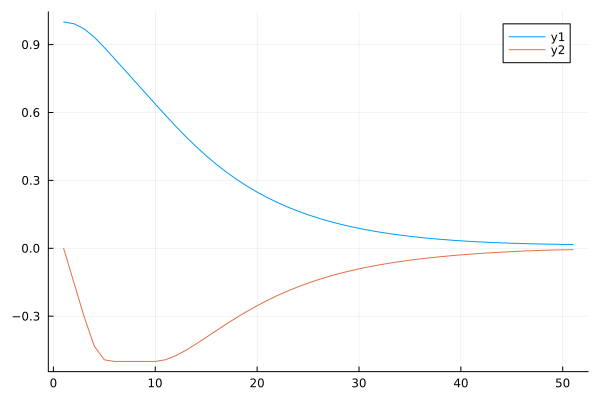

In [137]:
plot(x_solution_traj')

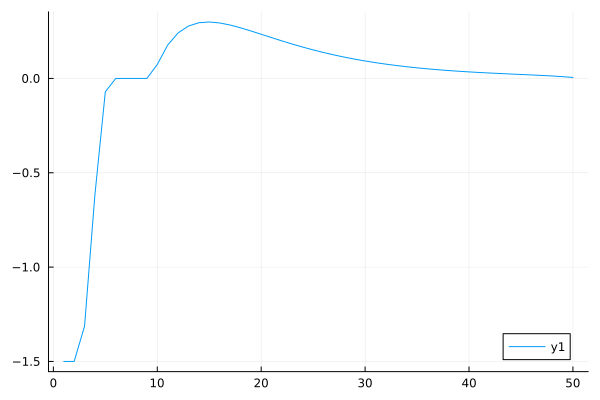

In [138]:
plot(u_solution_traj')

In [ ]:
#working!